In [14]:
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors
import pylab
from tqdm import tqdm

In [15]:
def load_input_geometry(folder_path):
    master_dir = Path(folder_path)
    
    input_geometry = {}
    
    for i in range(1, 65):
        run_dir = f"run{i}"
        run_path = master_dir / run_dir
        
        file_contents = []
        
        for j in range(1, 4):
            file_name = f"smesh.1.{j}.txt"
            file_path = run_path / file_name
            
            with open(file_path, 'r') as file:
                lines = file.readlines()
                content = np.array([line.strip().split() for line in lines[5:209]], dtype=float)[:,:-1].reshape(17, 12, 3)
                file_contents.append(content)
        
        input_geometry[run_dir] = np.array(file_contents)
    
    return input_geometry

def load_final_geometry(parent_folder):
    final_dir = Path(parent_folder) / "final_geometry"
    
    timesteps = [80, 140]
    pressures = ["p1", "p2", "p3"]
    temperatures = ["t1", "t2", "t3", "t4", "t5"]
    
    final_geometry = {}
    
    for i in range(1, 65):
        run_files = {}
        
        for timestep in timesteps:
            for pressure in pressures:
                for temperature in temperatures:
                    file_name = f"result_{timestep}_{temperature}_{pressure}_{i}"
                    file_path = final_dir / file_name
                    
                    if file_path.exists():
                        with open(file_path, 'r') as file:
                            lines = file.readlines()
                            content = np.array([line.strip().split() for line in lines[1:]], dtype=float)
                            reshaped_content = np.stack([arr.reshape(17, 12, 3) for arr in np.split(content, 3)])
                            label = f"{timestep}_{temperature}_{pressure}"
                            run_files[label] = reshaped_content
        
        run_label = f"run{i}"
        final_geometry[run_label] = run_files
    
    return final_geometry


In [21]:
input_geometry = load_input_geometry("DM/data/Input_geometry")

final_geometry = load_final_geometry("DM/data")

In [22]:
def create_ordered_pairs(input, output):
    ts80_ordered_pairs = []
    ts140_ordered_pairs = []
    keys = list(input.keys())

    for key in keys:
        input_geometry = input[key]
        output_geometries = output[key]
        output_keys = list(output[key].keys())

        for output_key in output_keys:
            if output_key[0:2]=='80':
                ts = output_key[0:2]
                temp = output_key[3:5]
                pressure = output_key[6:8]
                # ts80_ordered_pairs.append((key, input_geometry, temp, pressure, output_geometries[output_key]))
                pair = (key, input_geometry, temp, pressure, output_geometries[output_key])
                ts80_ordered_pairs += [(pair[0]+f'_{i}', pair[1][i], pair[2], pair[3], pair[4][i]) for i in range(0, 3)]
            elif output_key[0:3]=='140':
                ts = output_key[0:3]
                temp = output_key[4:6]
                pressure = output_key[7:9]
                # ts140_ordered_pairs.append((key, input_geometry, temp, pressure, output_geometries[output_key]))
                pair = (key, input_geometry, temp, pressure, output_geometries[output_key])
                ts140_ordered_pairs += [(pair[0]+f'_{i}', pair[1][i], pair[2], pair[3], pair[4][i]) for i in range(0, 3)]

    return ts80_ordered_pairs, ts140_ordered_pairs
                
ts80_ordered_pairs, ts140_ordered_pairs = create_ordered_pairs(input_geometry, final_geometry)

In [26]:
ts80_ordered_pairs[0][0]

'run1_0'

In [27]:
def pca_whitening(X, epsilon=1e-5):
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean
    cov = np.cov(X_centered, rowvar=False)
    
    cov = (cov + cov.T) / 2
    
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    adjusted_eigenvalues = np.maximum(eigenvalues, 0) + epsilon
    
    whitening_matrix = eigenvectors @ np.diag(1.0 / np.sqrt(adjusted_eigenvalues))
    X_whitened = X_centered @ whitening_matrix

    params = {'mean': X_mean, 'matrix': whitening_matrix}

    return X_whitened, params

In [28]:
input_data = np.vstack([arr.reshape(1, -1) for arr in list(input_geometry.values())])

whitened_inputs, pca_input_params = pca_whitening(input_data)

In [43]:
ts80_output_data = np.vstack([pair[4].reshape(1, -1) for pair in ts80_ordered_pairs])
ts80_data_labels = [pair[0]+'_'+pair[2]+'_'+pair[3] for pair in ts80_ordered_pairs]
ts140_output_data = np.vstack([pair[4].reshape(1, -1) for pair in ts140_ordered_pairs])
ts140_data_labels = [pair[0]+'_'+pair[2]+'_'+pair[3] for pair in ts140_ordered_pairs]

ts80_output_whitened, ts80_whiten_params = pca_whitening(ts80_output_data)
ts140_output_whitened, ts140_whiten_params = pca_whitening(ts140_output_data)

In [31]:
#
#  tsne.py
#
# Implementation of t-SNE in Python. The implementation was tested on Python
# 2.7.10, and it requires a working installation of NumPy. The implementation
# comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
#
# The example can be run by executing: `ipython tsne.py`
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.


def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P) + 1e-6
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations

    pbar = tqdm(range(max_iter))
    
    for iter in pbar:

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            pbar.set_description("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y




In [32]:
ts80_output_tsne = tsne(ts80_output_whitened)
ts140_output_tsne = tsne(ts140_output_whitened)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1941...
Computing P-values for point 500 of 1941...
Computing P-values for point 1000 of 1941...
Computing P-values for point 1500 of 1941...
Mean value of sigma: 0.550359


Iteration 1000: error is 0.623339: 100%|██████████████████| 1000/1000 [02:32<00:00,  6.56it/s]


Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1941...
Computing P-values for point 500 of 1941...
Computing P-values for point 1000 of 1941...
Computing P-values for point 1500 of 1941...
Mean value of sigma: 0.676155


Iteration 1000: error is 0.577563: 100%|██████████████████| 1000/1000 [02:27<00:00,  6.76it/s]


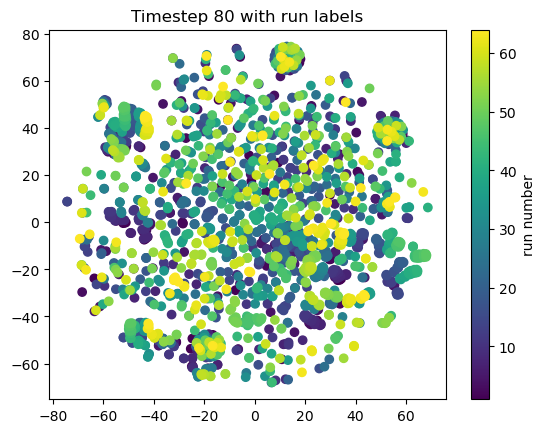

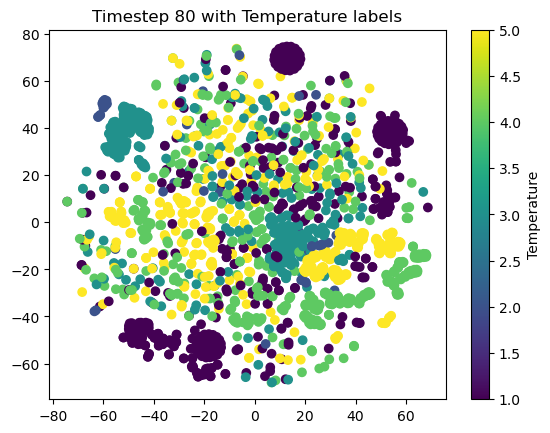

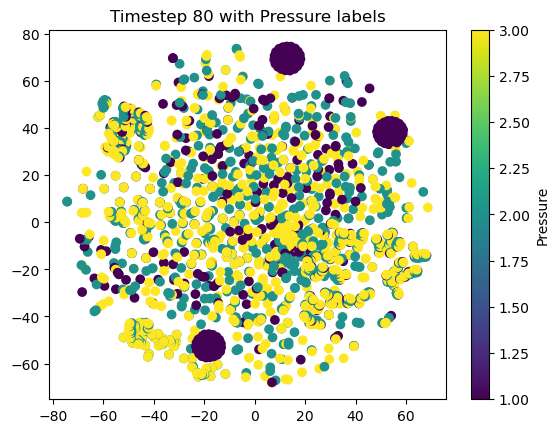

In [54]:
run_categories = np.array([int(label.split('_')[0][3:]) for label in ts80_data_labels])

x, y = ts80_output_tsne[:,0], ts80_output_tsne[:,1]
plt.scatter(x, y, c=run_categories, cmap='viridis')
plt.colorbar(label='run number')
plt.title("Timestep 80 with run labels")
plt.show()

temperature_categories = np.array([int(label.split('_')[2][1]) for label in ts80_data_labels])

x, y = ts80_output_tsne[:,0], ts80_output_tsne[:,1]
plt.scatter(x, y, c=temperature_categories, cmap='viridis')
plt.colorbar(label='Temperature')
plt.title("Timestep 80 with Temperature labels")
plt.show()

pressure_categories = np.array([int(label.split('_')[3][1]) for label in ts80_data_labels])
x, y = ts80_output_tsne[:,0], ts80_output_tsne[:,1]
plt.scatter(x, y, c=pressure_categories, cmap='viridis')
plt.colorbar(label='Pressure')
plt.title("Timestep 80 with Pressure labels")
plt.show()

# for i, label in enumerate(ts80_data_labels):
#     plt.annotate(label[0:5], (x[i], y[i]))

In [40]:
x.shape, run_categories.shape

((1941,), (1941,))

In [50]:
ts80_data_labels[0], ts80_data_labels[0].split('_')

('run1_0_t1_p1', ['run1', '0', 't1', 'p1'])